In [1]:
import pandas as pd
import wandb

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
sns.set_style("white", {"grid.color": ".6", "grid.linestyle": ":"})

In [2]:
def get_runs_df_stable_sig(project, entity="jurujin", runtime_limit=6*3600):
    '''
    Returns df with data from wandb project for stable-sig
    '''
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
        name_list.append(run.name)


    summary_df = pd.DataFrame(summary_list)
    config_df = pd.DataFrame(config_list)

    df = pd.concat([summary_df.reset_index(drop=True), config_df.reset_index(drop=True)], axis=1)
    df["name"] = name_list
    df = df[df["_runtime"] > runtime_limit]

    return df

# Чтобы выбрать долгие FID запуски надо: df["_runtime"] > 7200

def get_runs_df(project, entity="jurujin", runtime_limit=6*3600, resolution=False):
    '''
    Returns df with data from wandb project
    '''
    df = get_runs_df_stable_sig(project, entity, runtime_limit)

    if resolution:
        df["det_resol"] = df["no_w_det_dist_mean"] - df["w_det_dist_mean"]

    return df.sort_values(by=["w_radius", "msg_scaler"])

In [3]:
fid_projects = [
    # Все месседжи кроме 00..0 для всех S кроме 100
    "fid_gеn_message_s",
    "fid_gt_message_s",

    # Все месседжи для S=100
    "fid_gen_message_dependency",
    "fid_gt_message_dependency",

    # Месседжи 00..0 кроме S=100
    "worst_message_fid_gen",
    "worst_message_fid_gt"
]

fid_cols = [
    "name",
    "msg",
    "msg_scaler",
    "fid_w",
    "target_clean_generated"

]

In [4]:
dfs = []

for project in fid_projects:
    df = get_runs_df(project).sort_values(by="msg_scaler", ascending=False)[fid_cols]
    dfs.append(df)

In [5]:
unified_df = pd.concat(dfs).sort_values(by=["msg_scaler", "msg"], ascending=False)

In [6]:
useful_features = ["msg_scaler", "msg", "fid_w"]

df_gt = unified_df[unified_df["target_clean_generated"] == False]
df_gt = df_gt[df_gt["name"] != "random_msg"]
df_gt = df_gt[useful_features]

df_gen = unified_df[unified_df["target_clean_generated"] == True]
df_gen = df_gen[df_gen["name"] != "random_msg"]
df_gen = df_gen[useful_features]

In [7]:
df_gt.to_csv("gt.csv")
df_gen.to_csv("gen.csv")

In [8]:
df_gt[df_gt["msg_scaler"] == 100]["fid_w"].std()

2.2545685971478853

In [9]:
def get_stats_df(df):
    stds = [df[df["msg_scaler"] == S]["fid_w"].std() for S in range(60, 110, 10)]
    means = [df[df["msg_scaler"] == S]["fid_w"].mean() for S in range(60, 110, 10)]

    stats_dict = {
        "mean":means,
        "std":stds
    }
    
    return pd.DataFrame(data=stats_dict, index=range(60, 110, 10))


In [10]:
gt_stat = get_stats_df(df_gt)

In [11]:
gen_stat = get_stats_df(df_gen)

In [12]:
markersize=1
ticks_font = 16
label_font = 20
legend_font = 20

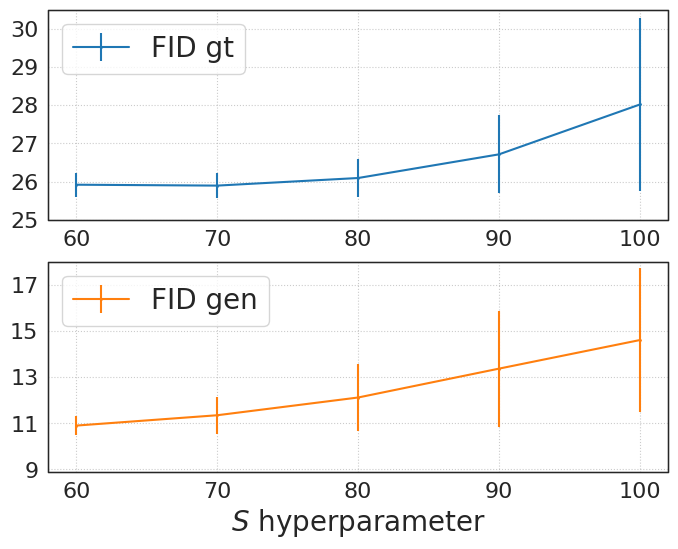

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

S = range(60, 110, 10)
axs[0].errorbar(S, gt_stat["mean"], yerr=gt_stat["std"], label='FID gt', fmt='-o', markersize=markersize, c="#1f77b4")
axs[1].errorbar(S, gen_stat["mean"], yerr=gen_stat["std"], label='FID gen', fmt='-o', markersize=markersize, c="#ff7f0e")

axs[0].set_ylim(25, 30.5)
axs[0].set_yticks(np.arange(25, 31, 1))

axs[1].set_ylim(8.9, 18)
axs[1].set_yticks(np.arange(9, 19, 2))

for ax in axs:
    ax.legend(loc="upper left" ,fontsize=legend_font)
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(1)
    ax.grid(alpha=0.5)
    ax.set_xlim(58, 102)
    ax.set_xticks(
        np.arange(60, 110, 10)
    )
    ax.tick_params(axis='both', which='major', labelsize=ticks_font)

ax.set_xlabel("$S$ hyperparameter", fontsize=label_font)

plt.savefig("fid_dispersion.png", bbox_inches='tight')